The purpose of this project is to suggest the play that will yield the most amount of yards based on different input parameters:

An initial exploration will encompass:

1. Time that the play will be called.
2. Position of the field at which the play will be called. 
3. Score of the Team that is calling the play. 
4. Quarter that play is called

For this initial exploration we will focus on the 2018 play by play data

After a successfull model has been predicted using this initial exploratory inputs the model will be expanded to include more complex inputs:

4. Injury data on both teams
5. Surface of Play
6. Attendance of the game
7. Penalties in the previous play
8. Weather
9. Altitude
 


In [6]:
import math
import sys
import timeit
import os
import shutil



import numpy as np
from numpy import *
import scipy.io as sio
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

In [17]:
path=os.getcwd()

names=[]
for file in os.listdir(path):
    if file.endswith(".csv"):
        #print(file)
        names.append(file)
names=sorted(names)

In [18]:
names

['pbp-2018.csv', 'uncleaned_nfl_game_metadata_since_1980.csv']

In [24]:
df=pd.read_csv(names[0])
df

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2018093004,2018-09-30,2,1,47,HOU,IND,1,8,92,NaN,0,NaN,0,(1:47) 26-L.MILLER LEFT GUARD TO IND 5 FOR 3 Y...,0,NaN,NaN,2018,3,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,LEFT GUARD,8,OPP,0,NaN,0,NaN,0
1,2018093004,2018-09-30,3,9,6,HOU,IND,1,10,83,NaN,0,NaN,0,(9:06) 26-L.MILLER RIGHT END TO IND 13 FOR 4 Y...,0,NaN,NaN,2018,4,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,RIGHT END,17,OPP,0,NaN,0,NaN,0
2,2018093004,2018-09-30,3,8,34,HOU,IND,2,6,87,NaN,0,NaN,0,(8:34) (SHOTGUN) 26-L.MILLER RIGHT TACKLE TO I...,0,NaN,NaN,2018,1,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,RIGHT TACKLE,13,OPP,0,NaN,0,NaN,0
3,2018093004,2018-09-30,3,7,53,HOU,IND,3,5,88,NaN,1,NaN,0,(7:53) (SHOTGUN) 4-D.WATSON PASS SHORT LEFT TO...,0,NaN,NaN,2018,6,SHOTGUN,PASS,0,1,0,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,12,OPP,0,NaN,0,NaN,0
4,2018093004,2018-09-30,3,7,24,HOU,IND,1,6,94,NaN,0,NaN,0,(7:24) 28-A.BLUE RIGHT END PUSHED OB AT IND 5 ...,0,NaN,NaN,2018,1,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,RIGHT END,6,OPP,0,NaN,0,NaN,0
5,2018093004,2018-09-30,5,7,13,IND,HOU,2,10,54,NaN,0,NaN,0,(7:13) (SHOTGUN) 12-A.LUCK PASS INCOMPLETE SHO...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,0,0,0,NaN,46,OPP,0,NaN,0,NaN,0
6,2018093004,2018-09-30,5,7,8,IND,HOU,3,10,54,NaN,1,NaN,0,"(7:08) (NO HUDDLE, SHOTGUN) 12-A.LUCK PASS SHO...",0,NaN,NaN,2018,13,NO HUDDLE SHOTGUN,PASS,0,1,0,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,0,0,0,NaN,46,OPP,0,NaN,0,NaN,0
7,2018093001,2018-09-30,2,2,53,TB,CHI,2,9,86,NaN,0,NaN,0,"(2:53) (NO HUDDLE, SHOTGUN) 14-R.FITZPATRICK P...",0,NaN,NaN,2018,0,NO HUDDLE SHOTGUN,PASS,0,1,1,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,14,OPP,0,NaN,0,NaN,0
8,2018093001,2018-09-30,2,2,46,TB,CHI,3,9,86,NaN,0,NaN,0,(2:46) (SHOTGUN) 14-R.FITZPATRICK PASS SHORT M...,0,NaN,NaN,2018,13,SHOTGUN,PASS,0,1,0,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,1,0,0,NaN,14,OPP,1,TB,1,OFFENSIVE PASS INTERFERENCE,10
9,2018093003,2018-09-30,2,15,0,GB,BUF,1,10,61,NaN,0,NaN,0,(15:00) (SHOTGUN) 12-A.RODGERS PASS SHORT RIGH...,0,NaN,NaN,2018,9,SHOTGUN,PASS,0,1,0,0,SHORT RIGHT,0,0,0,NaN,0,0,1,0,0,0,NaN,39,OPP,0,NaN,0,NaN,0


Filtering by Play time and comparing their mean value of yards obtained and histogram plots

In [45]:
df['IsRush'].count()

mask = (df['IsRush'] > 0) & (df['Yards'] > 0)

rush_data=df.loc[mask]

In [44]:
total_rushes=df['IsRush'].count()
print(total_rushes)

19269


In [47]:
total_positve_rushes=rush_data['IsRush'].count()

print(total_positve_rushes)

4417


In [48]:
probability_successfull_run=total_positve_rushes/total_rushes
print(probability_successfull_run)

0.22922829415122736


In [49]:
rush_data.describe()


,GameId,Quarter,Minute,Second,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,IsRush,IsPass,IsIncomplete,IsTouchdown,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,YardLineFixed,IsPenaltyAccepted,IsNoPlay,PenaltyYards
count,4.417000e+03,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,0.0,4417.000000,0.0,4417.0,4417.0,0.0,0.0,4417.0,4417.000000,4417.0,4417.0,4417.0,4417.000000,4417.0,4417.000000,4417.000000,0.0,4417.0,4417.0,4417.000000,4417.000000,4417.0,4417.0,4417.000000,4417.000000,4417.000000,4417.000000
mean,2.018096e+09,2.531130,7.158479,28.778130,1.580937,8.369255,48.316731,NaN,0.288431,NaN,0.0,0.0,NaN,NaN,2018.0,5.857596,1.0,0.0,0.0,0.040299,0.0,0.002264,0.000679,NaN,0.0,0.0,0.004754,0.055920,0.0,0.0,28.790355,0.052072,0.031243,0.470002
std,4.732189e+03,1.151752,4.418881,17.820427,0.734951,3.931673,24.831086,NaN,0.453084,NaN,0.0,0.0,NaN,NaN,0.0,6.285577,0.0,0.0,0.0,0.196681,0.0,0.047533,0.026055,NaN,0.0,0.0,0.068796,0.229794,0.0,0.0,13.017911,0.222196,0.173993,2.151964
min,2.018091e+09,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,NaN,0.000000,NaN,0.0,0.0,NaN,NaN,2018.0,1.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000
25%,2.018092e+09,1.000000,3.000000,13.000000,1.000000,6.000000,27.000000,NaN,0.000000,NaN,0.0,0.0,NaN,NaN,2018.0,2.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,20.000000,0.000000,0.000000,0.000000
50%,2.018093e+09,3.000000,7.000000,28.000000,1.000000,10.000000,45.000000,NaN,0.000000,NaN,0.0,0.0,NaN,NaN,2018.0,4.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,29.000000,0.000000,0.000000,0.000000
75%,2.018101e+09,4.000000,11.000000,44.000000,2.000000,10.000000,68.000000,NaN,1.000000,NaN,0.0,0.0,NaN,NaN,2018.0,7.000000,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.0,40.000000,0.000000,0.000000,0.000000
max,2.018102e+09,5.000000,15.000000,59.000000,4.000000,29.000000,99.000000,NaN,1.000000,NaN,0.0,0.0,NaN,NaN,2018.0,77.000000,1.0,0.0,0.0,1.000000,0.0,1.000000,1.000000,NaN,0.0,0.0,1.000000,1.000000,0.0,0.0,50.000000,1.000000,1.000000,15.000000


In [39]:
rush_data['Yards'].mean()

5.857595653158252

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x181ab22e48>]],
      dtype=object)

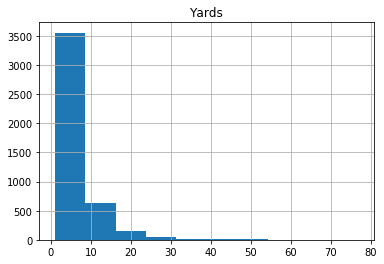

In [31]:
rush_data.hist(column='Yards')

In [33]:
mask = (df['IsPass'] > 0) & (df['Yards'] > 0)

pass_data=df.loc[mask]

pass_data.hist(column='Yards')

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
3,2018093004,2018-09-30,3,7,53,HOU,IND,3,5,88,NaN,1,NaN,0,(7:53) (SHOTGUN) 4-D.WATSON PASS SHORT LEFT TO...,0,NaN,NaN,2018,6,SHOTGUN,PASS,0,1,0,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,12,OPP,0,NaN,0,NaN,0
6,2018093004,2018-09-30,5,7,8,IND,HOU,3,10,54,NaN,1,NaN,0,"(7:08) (NO HUDDLE, SHOTGUN) 12-A.LUCK PASS SHO...",0,NaN,NaN,2018,13,NO HUDDLE SHOTGUN,PASS,0,1,0,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,0,0,0,NaN,46,OPP,0,NaN,0,NaN,0
8,2018093001,2018-09-30,2,2,46,TB,CHI,3,9,86,NaN,0,NaN,0,(2:46) (SHOTGUN) 14-R.FITZPATRICK PASS SHORT M...,0,NaN,NaN,2018,13,SHOTGUN,PASS,0,1,0,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,1,0,0,NaN,14,OPP,1,TB,1,OFFENSIVE PASS INTERFERENCE,10
9,2018093003,2018-09-30,2,15,0,GB,BUF,1,10,61,NaN,0,NaN,0,(15:00) (SHOTGUN) 12-A.RODGERS PASS SHORT RIGH...,0,NaN,NaN,2018,9,SHOTGUN,PASS,0,1,0,0,SHORT RIGHT,0,0,0,NaN,0,0,1,0,0,0,NaN,39,OPP,0,NaN,0,NaN,0
11,2018093006,2018-09-30,4,6,43,MIA,NE,4,2,50,NaN,1,NaN,0,(6:43) (SHOTGUN) 8-B.OSWEILER PASS SHORT RIGHT...,0,NaN,NaN,2018,11,SHOTGUN,PASS,0,1,0,0,SHORT RIGHT,0,0,0,NaN,0,0,0,0,0,0,NaN,50,OPP,0,NaN,0,NaN,0
13,2018093006,2018-09-30,4,5,36,MIA,NE,2,7,64,NaN,1,NaN,0,(5:36) (SHOTGUN) 8-B.OSWEILER PASS SHORT LEFT ...,0,NaN,NaN,2018,8,SHOTGUN,PASS,0,1,0,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,36,OPP,0,NaN,0,NaN,0
18,2018093005,2018-09-30,4,12,4,NYJ,JAX,2,4,96,NaN,0,NaN,0,(12:04) 14-S.DARNOLD PASS SHORT LEFT TO 86-J.L...,0,NaN,NaN,2018,2,UNDER CENTER,PASS,0,1,0,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,4,OPP,0,NaN,0,NaN,0
20,2018093005,2018-09-30,4,2,35,JAX,NYJ,3,1,60,NaN,0,NaN,0,(2:35) (SHOTGUN) 5-B.BORTLES PASS SHORT MIDDLE...,0,NaN,NaN,2018,20,SHOTGUN,PASS,0,1,0,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,1,0,0,NaN,40,OPP,1,NYJ,0,UNNECESSARY ROUGHNESS,10
26,2018093008,2018-09-30,4,0,44,SEA,ARI,1,10,60,NaN,0,NaN,0,"(:44) (NO HUDDLE, SHOTGUN) 3-R.WILSON PASS SHO...",0,NaN,NaN,2018,6,NO HUDDLE SHOTGUN,PASS,0,1,0,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,40,OPP,0,NaN,0,NaN,0
32,2018093009,2018-09-30,4,3,48,OAK,CLE,1,10,53,NaN,0,NaN,0,"(3:48) (NO HUDDLE, SHOTGUN) 4-D.CARR PASS SHOR...",0,NaN,NaN,2018,5,NO HUDDLE SHOTGUN,PASS,0,1,0,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,47,OPP,0,NaN,0,NaN,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1818172978>]],
      dtype=object)

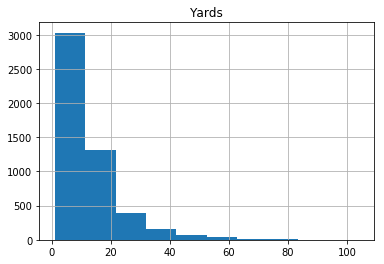

In [35]:

pass_data.hist(column='Yards')

In [37]:
pass_data['Yards'].mean()

12.546395858223816

In [51]:
mask = (df['IsIncomplete'] > 0) 

pass_data_incomplete=df.loc[mask]

pass_data_incomplete[:]

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
5,2018093004,2018-09-30,5,7,13,IND,HOU,2,10,54,NaN,0,NaN,0,(7:13) (SHOTGUN) 12-A.LUCK PASS INCOMPLETE SHO...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,0,0,0,NaN,46,OPP,0,NaN,0,NaN,0
7,2018093001,2018-09-30,2,2,53,TB,CHI,2,9,86,NaN,0,NaN,0,"(2:53) (NO HUDDLE, SHOTGUN) 14-R.FITZPATRICK P...",0,NaN,NaN,2018,0,NO HUDDLE SHOTGUN,PASS,0,1,1,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,14,OPP,0,NaN,0,NaN,0
10,2018093003,2018-09-30,2,14,33,GB,BUF,2,1,70,NaN,0,NaN,0,(14:33) 12-A.RODGERS PASS INCOMPLETE DEEP RIGH...,0,NaN,NaN,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,NaN,0,0,0,0,0,0,NaN,30,OPP,0,NaN,0,NaN,0
17,2018093005,2018-09-30,3,5,5,NYJ,JAX,3,9,91,NaN,0,NaN,0,(5:05) (SHOTGUN) 14-S.DARNOLD PASS INCOMPLETE ...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,0,0,0,NaN,9,OPP,0,NaN,0,NaN,0
33,2018093010,2018-09-30,2,10,40,SF,LAC,2,10,57,NaN,0,NaN,0,(10:40) (SHOTGUN) 3-C.BEATHARD PASS INCOMPLETE...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,43,OPP,0,NaN,0,NaN,0
34,2018093010,2018-09-30,2,10,34,SF,LAC,3,10,57,NaN,0,NaN,0,(10:34) (SHOTGUN) 3-C.BEATHARD PASS INCOMPLETE...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,DEEP LEFT,0,0,0,NaN,0,0,0,1,0,0,NaN,43,OPP,1,LAC,1,ILLEGAL CONTACT,5
38,2018093012,2018-09-30,2,8,28,PIT,BAL,2,4,64,NaN,0,NaN,0,"(8:28) (NO HUDDLE, SHOTGUN) 7-B.ROETHLISBERGER...",0,NaN,NaN,2018,0,NO HUDDLE SHOTGUN,PASS,0,1,1,0,SHORT RIGHT,0,0,0,NaN,0,0,0,0,0,0,NaN,36,OPP,0,NaN,0,NaN,0
42,2018093012,2018-09-30,2,6,38,PIT,BAL,2,3,80,NaN,0,NaN,0,"(6:38) (NO HUDDLE, SHOTGUN) 7-B.ROETHLISBERGER...",0,NaN,NaN,2018,0,NO HUDDLE SHOTGUN,PASS,0,1,1,0,SHORT RIGHT,0,0,0,NaN,0,0,0,0,0,0,NaN,20,OPP,0,NaN,0,NaN,0
45,2018093011,2018-09-30,3,7,25,NO,NYG,3,6,82,NaN,0,NaN,0,(7:25) (SHOTGUN) 9-D.BREES PASS INCOMPLETE SHO...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT MIDDLE,0,0,0,NaN,0,0,0,1,0,0,NaN,18,OPP,1,NYG,1,FACE MASK (15 YARDS),9
47,2018100100,2018-10-01,4,0,28,DEN,KC,2,10,72,NaN,0,NaN,0,(:28) (SHOTGUN) 4-C.KEENUM PASS INCOMPLETE SHO...,0,NaN,NaN,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT LEFT,0,0,0,NaN,0,0,0,0,0,0,NaN,28,OPP,0,NaN,0,NaN,0


In [56]:
mask = (df['IsInterception'] > 0) 

pass_data_inter=df.loc[mask]




In [52]:
pass_data_incomplete['Yards'].count()

2754

In [57]:
probability_pass=pass_data['Yards'].count()/(pass_data_incomplete['Yards'].count()+pass_data['Yards'].count()+pass_data_inter['Yards'].count())
print(probability_pass)

0.6296389167502507


# Preliminary Conclusions



Based in this initial exploration and without any other consideration throwing a Pass will yield more yards since  it has a higher mean than running the ball and also has higher probabilities of success. 

These results have to be further down refined to include more variables and to make the model more robust. 